In [1]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime

from tradealgorithm.tradealgorithm import TradeAlgorithm
from tradealgorithm.tradealgorithmfactory import TradeAlgorithmFactory
from pricer.pricer_factory import PricerFactory
from pricer.pricer import Pricer
from ranker.ranker_factory import RankerFactory
from ranker.ranker import Ranker
from classifier.classifier_factory import ClassifierFactory
from classifier.classifier import Classifier
from datetime import datetime

## risk and return class imports
from returns.products import Products as returns_products_class

## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
start = datetime(2020,1,1)
end  = datetime.now()
current_date = datetime.now()

In [3]:
market = Market()

In [4]:
pricer_classes = [] 
pricer_classes.append(Pricer.WEEKLY_STOCK_ROLLING)
pricer_classes.append(Pricer.WEEKLY_STOCK_WINDOW)
pricer_classes.append(Pricer.DAILY_STOCK_ROLLING)
pricer_classes.append(Pricer.DAILY_STOCK_WINDOW)
pricer_classes.append(Pricer.MONTHLY_STOCK_ROLLING)
pricer_classes.append(Pricer.MONTHLY_STOCK_WINDOW)
# pricer_classes.append(Pricer.DAILY_STOCK_MEANREVERSION)
# pricer_classes.append(Pricer.DAILY_STOCK_DEVROLLING)
# pricer_classes.append(Pricer.DAILY_STOCK_BREAKOUT)

In [5]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [6]:
market.connect()
tyields = returns_products_class.tyields(market.retrieve("tyields10"),10)
bench_returns = returns_products_class.spy_bench(market.retrieve("spy"))
market.disconnect()
current = False
ranker_class = Ranker.NONE
classifier_class = Classifier.NONE

In [17]:
analysis = []
trade_algos = []
for pricer_class in tqdm(pricer_classes):
    trade_algo = TradeAlgorithmFactory.build(TradeAlgorithm.RRR_BETA)
    trade_algo.initialize(pricer_class,ranker_class,classifier_class,start,end,current_date)
    trade_algo.initialize_bench_and_yields()
    trade_algo.initialize_classes()
    trade_algos.append(trade_algo)
    trade_algo.db.connect()
    trade_algo.load_optimal_parameter()
    parameter = trade_algo.parameter
    try:
        trade = trade_algo.pull_performance()
        if trade.index.size > 0:
            positions = int(trade_algo.positions) if trade_algo.pricer_class.asset_class.value == "stocks" else 1
            pricer_timeframe =  trade_algo.pricer_class.time_horizon_class.naming_convention
            trade = trade[trade["position"] <= positions]
            ledger = trade.sort_values(["year",pricer_timeframe]).copy()
            anas = trade_algo.analysis
            if ledger.index.size > 0:
                cumulative = anas.trade_analysis(ledger,positions,tyields,bench_returns)
                cumulative["trade_algo"] = trade_algo.name
                for key in parameter.keys():
                    if key not in ["pv","beta","rrr","sharpe"]:
                        cumulative[key] = parameter[key]
                trade_algo.db.cloud_connect()
                trade_algo.db.drop("analysis")
                trade_algo.db.store("analysis",cumulative[["year",pricer_timeframe,"pv"]])
                trade_algo.db.disconnect()
                analysis.append(cumulative[list(parameter.keys()) + ["trade_algo","pv","beta","rrr","sharpe"]].iloc[-1])
    except Exception as e:
        print(str(e))
        continue
    trade_algo.db.disconnect()
a = pd.DataFrame([x.to_dict() for x in analysis])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.68s/it]


In [40]:
a.sort_values("pv",ascending=False).head(20)

,trade_algo,value,ceiling,classification,rank,risk,floor_value,tyields,buy_day,iteration,pv,beta,rrr,sharpe
5,msw_n_n_b_r,True,False,False,False,none,1,tyield1,1,2,3.568491,-0.776905,0.801244,-3.302669
1,wsw_n_n_b_r,True,False,False,False,flat,1,tyield1,1,0,3.224554,-1.350732,0.238647,-1.646476
0,wsr_n_n_b_r,True,False,False,False,none,1,tyield1,1,2,2.732993,-1.123908,0.369126,-1.541395
4,msr_n_n_b_r,True,False,False,False,none,1,tyield1,1,2,2.378666,-0.766022,0.804065,-1.796337
3,dsw_n_n_b_r,True,False,False,False,none,1,tyield1,1,2,1.602895,-0.031776,0.989640,-18.970591
2,dsr_n_n_b_r,True,False,False,False,flat,1,tyield1,1,0,1.427903,-0.057156,0.981317,-7.485055


In [41]:
top_by_strategy = a.sort_values("pv",ascending=False).groupby("trade_algo").nth(0).reset_index().sort_values("pv",ascending=False)
top_by_strategy

,trade_algo,value,ceiling,classification,rank,risk,floor_value,tyields,buy_day,iteration,pv,beta,rrr,sharpe
3,msw_n_n_b_r,True,False,False,False,none,1,tyield1,1,2,3.568491,-0.776905,0.801244,-3.302669
5,wsw_n_n_b_r,True,False,False,False,flat,1,tyield1,1,0,3.224554,-1.350732,0.238647,-1.646476
4,wsr_n_n_b_r,True,False,False,False,none,1,tyield1,1,2,2.732993,-1.123908,0.369126,-1.541395
2,msr_n_n_b_r,True,False,False,False,none,1,tyield1,1,2,2.378666,-0.766022,0.804065,-1.796337
1,dsw_n_n_b_r,True,False,False,False,none,1,tyield1,1,2,1.602895,-0.031776,0.989640,-18.970591
0,dsr_n_n_b_r,True,False,False,False,flat,1,tyield1,1,0,1.427903,-0.057156,0.981317,-7.485055


In [42]:
top = a.sort_values("pv",ascending=False).iloc[0]
db = ADatabase(top["trade_algo"])
db.connect()
analysis = db.retrieve("performance")
db.disconnect()

In [43]:
trade_algo_name = top["trade_algo"]
trade_algo_class = [x for x in trade_algos if x.name == trade_algo_name][0]
anas = trade_algo_class.analysis
naming = trade_algo_class.pricer_class.time_horizon_class.naming_convention
ledger = analysis[["year",naming,"ticker",f"{naming}ly_delta",f"{naming}ly_delta_sign","actual_returns","position"]]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

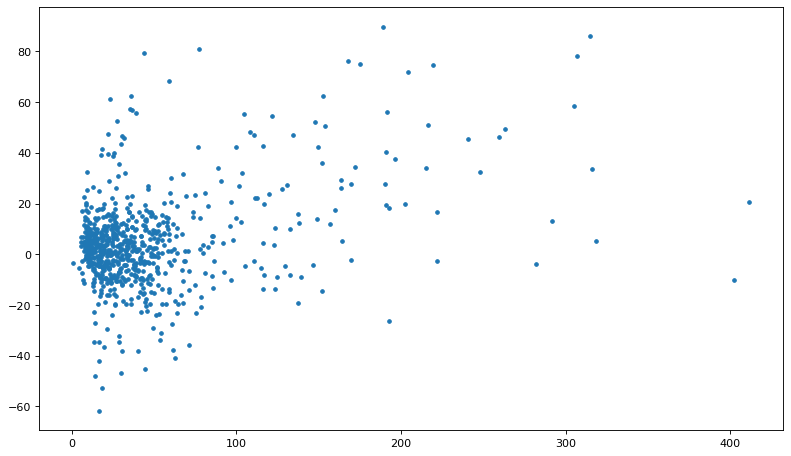

In [44]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger[f"{naming}ly_delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [45]:
ledger.sort_values(["year",naming,"position"],ascending=True).head(20)

,year,month,ticker,monthly_delta,monthly_delta_sign,actual_returns,position,GICS Sector,Security
0,2020,2,PSX,0.296678,1.0,0.530341,0,Energy,Phillips 66
38,2020,2,BWA,0.286497,1.0,0.652589,1,Consumer Discretionary,BorgWarner
76,2020,2,DD,0.283656,1.0,0.678325,2,Materials,DuPont
114,2020,2,ABMD,0.228041,1.0,0.859467,3,Health Care,Abiomed
152,2020,2,AAP,0.213948,1.0,0.706932,4,Consumer Discretionary,Advance Auto Parts
189,2020,2,DLTR,0.211003,1.0,0.839372,5,Consumer Discretionary,Dollar Tree
226,2020,2,CF,0.194875,1.0,0.632862,6,Materials,CF Industries
263,2020,2,VLO,0.181660,1.0,0.472855,7,Energy,Valero Energy
300,2020,2,KHC,0.174957,1.0,0.889322,8,Consumer Staples,Kraft Heinz
337,2020,2,CTRA,0.166147,1.0,1.247712,9,Energy,Coterra


In [46]:
ledger.sort_values("actual_returns",ascending=False).head(20)

,year,month,ticker,monthly_delta,monthly_delta_sign,actual_returns,position,GICS Sector,Security
560,2020,3,PENN,1.888982,1.0,1.897681,15,Consumer Discretionary,Penn National Gaming
3,2020,5,NCLH,3.149684,1.0,1.862038,0,Consumer Discretionary,Norwegian Cruise Line Holdings
8,2020,10,OXY,0.772714,1.0,1.810140,0,Energy,Occidental Petroleum
84,2020,10,FANG,0.439265,1.0,1.793909,2,Energy,Diamondback Energy
77,2020,3,APA,3.068859,1.0,1.780269,2,Energy,APA Corporation
229,2020,5,AAL,1.675794,1.0,1.763731,6,Industrials,American Airlines Group
155,2020,5,RCL,1.748901,1.0,1.749862,4,Consumer Discretionary,Royal Caribbean Group
41,2020,5,UAL,2.194893,1.0,1.745167,1,Industrials,United Airlines Holdings
79,2020,5,CZR,2.042498,1.0,1.719586,2,Consumer Discretionary,Caesars Entertainment
46,2020,10,APA,0.592685,1.0,1.682445,1,Energy,APA Corporation


In [47]:
ledger["actual_returns"].mean()

1.0451523229491986

In [48]:
ledger[ledger["actual_returns"]>1].index.size / ledger.index.size

0.5994623655913979

In [49]:
portfolio = ledger.pivot_table(index=["year",naming],columns="position",values="actual_returns").fillna(1).reset_index()

In [50]:
portfolio.head(20)

position,year,month,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,2020,2,0.530341,0.652589,0.678325,0.859467,0.706932,0.839372,0.632862,0.472855,...,0.581095,0.653935,0.382228,0.918836,0.956421,0.729287,0.520573,0.889723,0.653643,0.773896
1,2020,3,1.204387,1.336949,1.780269,1.584737,1.131922,1.494315,1.456117,0.974036,...,1.342105,1.200176,1.181281,1.193093,1.275477,1.897681,1.276173,1.052143,1.263183,1.175930
2,2020,4,0.897976,1.054357,0.960359,1.463415,1.324950,1.374836,0.736570,1.402353,...,1.117607,1.361142,0.856968,0.911475,1.121696,0.807869,1.099099,0.920213,1.103293,0.864734
3,2020,5,1.862038,1.745167,1.719586,1.561031,1.749862,1.346223,1.763731,1.504517,...,1.522002,1.274438,1.257846,1.544879,1.425414,1.471474,1.482104,1.553381,1.267833,1.421268
4,2020,6,1.014332,0.945129,0.944329,0.963852,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,2020,7,1.060300,1.028806,1.134114,1.046897,0.990188,0.985025,1.085730,1.031012,...,1.044024,1.049835,1.049802,1.116441,1.049512,1.067461,1.170451,0.928286,1.032625,1.047884
6,2020,8,0.966184,1.040812,0.964244,0.989627,1.173258,1.057249,1.062103,0.930113,...,1.185979,1.013293,1.004387,1.015274,1.065285,1.037013,1.062347,0.987867,1.201601,1.135376
7,2020,9,0.927928,0.992788,0.851603,0.802872,0.881364,0.964922,0.901897,1.167483,...,0.877141,0.957410,0.956906,0.881783,0.944094,1.037533,0.919145,1.104048,0.957866,0.908046
8,2020,10,1.810140,1.682445,1.793909,1.020312,1.556418,1.570262,1.573742,1.459386,...,1.309288,1.527360,1.401154,1.003999,1.155682,1.396017,1.473161,1.037459,0.949929,1.416192
9,2020,11,1.136187,1.089330,1.150384,1.199228,1.052707,1.089051,0.972515,1.017165,...,1.144465,1.068929,1.058274,1.266886,1.015085,0.963187,1.011451,0.966498,1.013982,0.960045


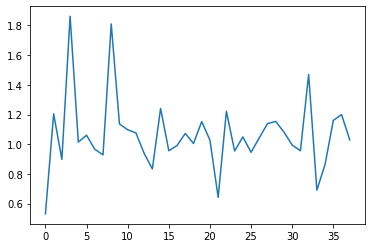

In [51]:
plt.plot(portfolio[0])

In [52]:
positions = ledger["position"].max()

In [53]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [54]:
cumulative.tail(10)

,0,1,2,3,4,5,6,7,8,9,...,17,18,year,month,date,week,pv,daily_returns,adjclose,bench
28,2.983515,3.219481,1.921788,1.900455,2.466787,6.336305,1.859354,1.298000,3.619797,5.407727,...,1.684292,3.225197,2022,8,2022-08-28,34,3.329315,1.018268,12967.8560,1.334228
29,3.226596,3.077137,1.890639,1.770653,2.248017,6.935685,1.814015,1.184276,3.540718,4.812441,...,1.595437,3.245212,2022,9,2022-09-28,39,3.261156,0.965227,11223.0000,1.154705
30,3.207738,3.343696,1.704314,1.510820,2.199108,7.085916,1.126058,1.078522,3.328637,4.308401,...,1.637634,3.304901,2022,10,2022-10-28,43,3.176955,0.972852,10720.6540,1.103020
31,3.066885,3.043203,1.567909,1.405863,2.728096,4.416599,1.465234,1.091587,3.815783,4.472193,...,1.647203,2.916900,2022,11,2022-11-28,48,3.193015,1.026349,11177.6500,1.150039
32,4.505313,3.771702,1.891843,1.368587,3.075721,4.862162,1.750729,1.197097,6.201165,5.289008,...,1.750534,4.042588,2022,12,2022-12-28,52,3.871440,1.204785,10555.2980,1.086006
33,3.110518,3.883553,1.854357,1.272231,2.751864,4.737967,1.611811,1.133440,5.601052,5.687703,...,1.799241,3.652146,2023,2,2023-02-28,9,3.693691,0.952437,11496.1775,1.182811
34,2.690845,3.174135,2.002970,1.289173,2.986577,4.719422,1.563811,1.097546,5.231856,6.296404,...,1.767095,4.083168,2023,3,2023-03-28,13,3.757728,1.012918,11763.3940,1.210304
35,3.122861,2.643753,1.538295,1.195827,2.268701,3.657649,1.271174,0.994411,4.305453,5.053864,...,1.602440,3.263862,2023,4,2023-04-28,17,3.258525,0.867111,12120.0760,1.247002
36,3.745805,3.230041,1.497939,1.579798,2.399448,4.514449,1.484050,1.223258,3.845978,5.467454,...,1.779298,3.761140,2023,5,2023-05-28,21,3.525137,1.111639,12511.1140,1.287235
37,3.854917,3.406828,1.630783,1.527880,2.795117,4.247437,1.535588,1.238432,4.024875,5.455391,...,1.785239,4.118851,2023,6,2023-06-28,26,3.697048,1.044140,13573.1550,1.396506


In [55]:
cash_analysis = cumulative.copy()
cash_analysis["previous_day"] = cash_analysis["daily_returns"].shift(1)
cash_analysis["base"] = [min(row[1]["previous_day"],1) for row in cash_analysis.iterrows()]
cash_analysis["real_return"] = cash_analysis["base"] * cash_analysis["daily_returns"]
cash_analysis["cash"] = [max(0,row[1]["real_return"]-1) * 100 for row in cash_analysis.iterrows()]
cash_analysis["running_cash"] = cash_analysis["cash"].cumsum()

In [56]:
cash_analysis["cash"].sum()

199.35763983167385

In [57]:
cash_analysis[["daily_returns","base","real_return","cash","running_cash"]]

,daily_returns,base,real_return,cash,running_cash
0,0.726080,NaN,NaN,0.000000,0.000000
1,1.332763,0.726080,0.967693,0.000000,0.000000
2,1.093895,1.000000,1.093895,9.389541,9.389541
3,1.531569,1.000000,1.531569,53.156925,62.546466
4,0.993034,1.000000,0.993034,0.000000,62.546466
5,1.049272,0.993034,1.041963,4.196270,66.742736
6,1.039434,1.000000,1.039434,3.943448,70.686183
7,0.960109,1.000000,0.960109,0.000000,70.686183
8,1.401184,0.960109,1.345289,34.528938,105.215122
9,1.075238,1.000000,1.075238,7.523832,112.738954


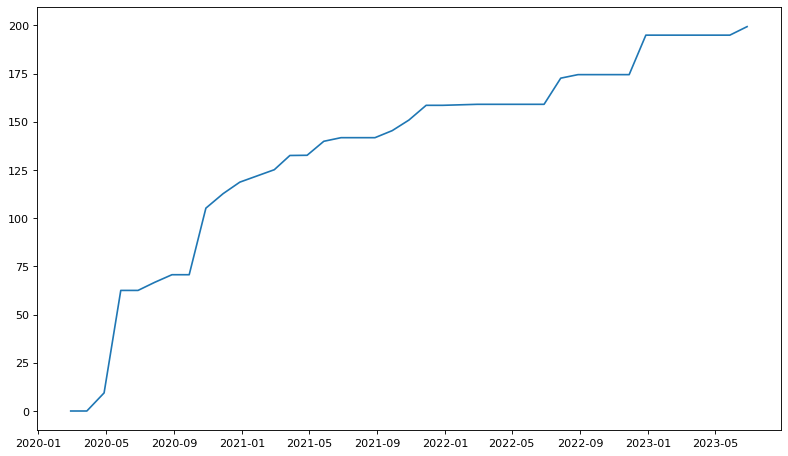

In [58]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cash_analysis["date"],cash_analysis["running_cash"])

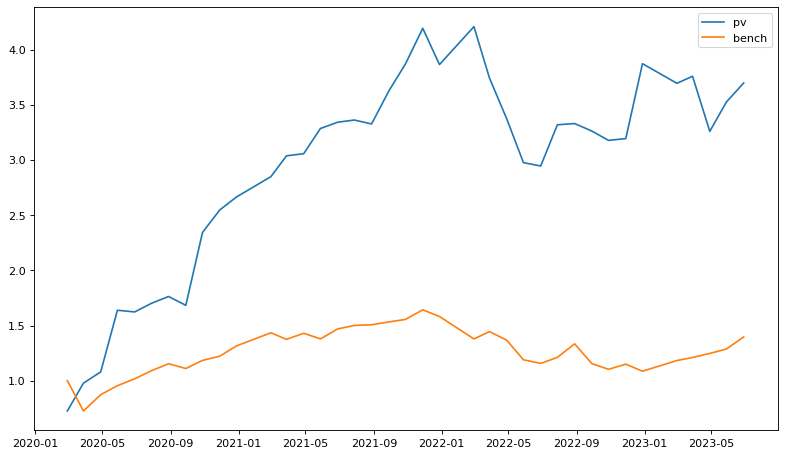

In [59]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [60]:
cumulative.head(20)

,0,1,2,3,4,5,6,7,8,9,...,17,18,year,month,date,week,pv,daily_returns,adjclose,bench
0,0.530341,0.652589,0.678325,0.859467,0.706932,0.839372,0.632862,0.472855,0.889322,1.247712,...,0.889723,0.653643,2020,2,2020-02-28,9,0.726080,0.726080,9719.36925,1.000000
1,0.638736,0.872478,1.207601,1.362030,0.800192,1.254286,0.921521,0.460578,1.039180,1.883980,...,0.936115,0.825670,2020,3,2020-03-28,13,0.978056,1.332763,7051.86260,0.725547
2,0.573569,0.919903,1.159731,1.993215,1.060214,1.724438,0.678764,0.645893,1.016862,2.432805,...,0.861425,0.910956,2020,4,2020-04-28,18,1.080021,1.093895,8489.72200,0.873485
3,1.068007,1.605385,1.994257,3.111471,1.855228,2.321479,1.197157,0.971757,1.651813,3.463994,...,1.338121,1.154940,2020,5,2020-05-28,22,1.638414,1.531569,9281.03580,0.954901
4,1.083314,1.517296,1.883234,2.998997,1.855228,2.321479,1.197157,0.971757,1.651813,3.463994,...,1.338121,1.154940,2020,6,2020-06-28,26,1.622821,0.993034,9884.31940,1.016971
5,1.148638,1.561003,2.135803,3.139640,1.837025,2.286715,1.299790,1.001893,1.647971,3.699500,...,1.242160,1.192621,2020,7,2020-07-28,31,1.700593,1.049272,10595.63600,1.090157
6,1.109796,1.624710,2.059434,3.107071,2.155304,2.417627,1.380510,0.931874,1.626955,3.719374,...,1.227088,1.433054,2020,8,2020-08-28,35,1.762846,1.039434,11212.75720,1.153651
7,1.029811,1.612994,1.753820,2.494580,1.899607,2.332822,1.245078,1.087947,1.652862,4.088941,...,1.354764,1.372674,2020,9,2020-09-28,40,1.682756,0.960109,10792.24940,1.110386
8,1.864102,2.713773,3.146193,2.545250,2.956582,3.663141,1.959431,1.587734,2.425763,5.864460,...,1.405511,1.303942,2020,10,2020-10-28,44,2.342968,1.401184,11506.87180,1.183911
9,2.117967,2.956195,3.619331,3.052335,3.112413,3.989348,1.905577,1.614988,2.512687,6.910507,...,1.358423,1.322174,2020,11,2020-11-28,48,2.546533,1.075238,11876.95000,1.221988


In [61]:
# plt.figure(figsize=(12, 7), dpi=80)
# position_columns = [x for x in cumulative.columns if x not in ["year","week","quarter","date_string","date","pv","adjclose","bench"]]
# for i in position_columns:
#     position = cumulative[i]
#     plt.plot(cumulative["date"],position)
# plt.show()


In [62]:
ledger.groupby(["GICS Sector"]).mean().sort_values("actual_returns",ascending=False)

,year,month,monthly_delta,monthly_delta_sign,actual_returns,position
GICS Sector,,,,,,
Energy,2020.636364,6.613636,0.657450,1.0,1.143323,8.704545
Real Estate,2021.238095,6.714286,0.351778,1.0,1.081444,12.666667
Utilities,2020.840000,4.680000,0.182394,1.0,1.054112,8.320000
Industrials,2020.816667,6.566667,0.558848,1.0,1.047829,10.700000
Consumer Discretionary,2021.453901,6.524823,0.661459,1.0,1.045713,8.758865
Health Care,2021.252525,7.555556,0.307457,1.0,1.034714,9.676768
Financials,2021.983333,5.516667,0.450991,1.0,1.029238,9.883333
Information Technology,2021.385965,6.605263,0.340197,1.0,1.024421,9.824561
Communication Services,2021.743590,7.141026,0.510610,1.0,1.015786,8.141026


In [63]:
ledger.groupby(["year",naming,"ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(30)

monthly_delta  \
year month ticker Security                                        
2020 3     PENN   Penn National Gaming                 1.888982   
     5     NCLH   Norwegian Cruise Line Holdings       3.149684   
     10    OXY    Occidental Petroleum                 0.772714   
           FANG   Diamondback Energy                   0.439265   
     3     APA    APA Corporation                      3.068859   
     5     AAL    American Airlines Group              1.675794   
           RCL    Royal Caribbean Group                1.748901   
           UAL    United Airlines Holdings             2.194893   
           CZR    Caesars Entertainment                2.042498   
     10    APA    APA Corporation                      0.592685   
2022 12    WBD    Warner Bros. Discovery               0.360960   
2020 5     BA     Boeing                               1.523140   
2021 10    ENPH   Enphase                              0.231236   
2020 3     CZR    Caesars Entertainment                3.050850   
     10    EOG    EOG Resources                        0.354344   
           MRO    Marathon Oil                         0.361765   
     5     CCL    Carnival                             1.916607   
     10    VLO    Valero Energy                        0.386406   
     5     BBWI   Bath & Body Works, Inc.              1.043197   
           ALK    Alaska Air Group                     1.213303   
     10    MPC    Marathon Petroleum                   0.275948   
     5     SPG    Simon Property Group                 1.478499   
     3     MGM    MGM Resorts                          2.162883   
     5     DAL    Delta Air Lines                      1.537021   
     3     FANG   Diamondback Energy                   2.633226   
     5     MGM    MGM Resorts                          1.079519   
     10    SLB    Schlumberger                         0.215908   
     5     LUV    Southwest Airlines                   1.103425   
2022 12    TSLA   Tesla, Inc.                          1.344578   
2020 10    COP    ConocoPhillips                       0.302185   

                                                  monthly_delta_sign  \
year month ticker Security                                             
2020 3     PENN   Penn National Gaming                           1.0   
     5     NCLH   Norwegian Cruise Line Holdings                 1.0   
     10    OXY    Occidental Petroleum                           1.0   
           FANG   Diamondback Energy                             1.0   
     3     APA    APA Corporation                                1.0   
     5     AAL    American Airlines Group                        1.0   
           RCL    Royal Caribbean Group                          1.0   
           UAL    United Airlines Holdings                       1.0   
           CZR    Caesars Entertainment                          1.0   
     10    APA    APA Corporation                                1.0   
2022 12    WBD    Warner Bros. Discovery                         1.0   
2020 5     BA     Boeing                                         1.0   
2021 10    ENPH   Enphase                                        1.0   
2020 3     CZR    Caesars Entertainment                          1.0   
     10    EOG    EOG Resources                                  1.0   
           MRO    Marathon Oil                                   1.0   
     5     CCL    Carnival                                       1.0   
     10    VLO    Valero Energy                                  1.0   
     5     BBWI   Bath & Body Works, Inc.                        1.0   
           ALK    Alaska Air Group                               1.0   
     10    MPC    Marathon Petroleum                             1.0   
     5     SPG    Simon Property Group                           1.0   
     3     MGM    MGM Resorts                                    1.0   
     5     DAL    Delta Air Lines                                1.0   
     3     FANG   Diamondback Ene

In [64]:
industry_analysis = ledger.pivot_table(index=["year",naming],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x not in  ["year","month","sell_date"]]].cumprod()

GICS Sector,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,1.000000,0.732964,0.922872,0.750303,0.773896,0.859467,0.730262,0.655191,0.627868,1.000000,1.000000
1,1.193093,1.039311,0.922872,0.969241,0.987626,0.859467,0.858738,0.954035,0.793112,1.000000,1.000000
2,1.338288,1.072123,0.922872,1.222247,1.089640,0.859467,0.717496,0.954035,0.793112,1.000000,1.000000
3,1.338288,1.774007,0.922872,1.611799,1.467336,0.859467,1.127535,0.954035,0.793112,1.471635,1.000000
4,1.338288,1.774007,0.889512,1.611799,1.488365,0.859467,1.065667,0.954035,0.793112,1.471635,0.944329
5,1.338288,1.862357,0.962074,1.749979,1.542605,0.945095,1.104559,1.001271,0.793112,1.366098,0.984800
6,1.338288,2.186507,0.962074,1.706790,1.637116,0.958594,1.173425,1.040233,0.793112,1.390850,0.951498
7,1.338288,2.186507,0.962074,1.581461,1.807454,0.958594,1.217467,1.040233,0.793112,1.390850,1.038754
8,1.875147,2.186507,0.962074,2.439583,1.807454,0.950363,1.217467,1.140689,0.793112,1.969711,1.038754
9,2.209618,2.219489,0.952684,2.568165,1.807454,1.018398,1.217467,1.303701,0.800376,1.969711,1.038754
